In [1]:
import numpy as np
import os
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objects as go

init_notebook_mode()


# data

Data set from paper found at https://github.com/tufts-ml/false-alarm-control/blob/main/toy_example_comparing_BCE_Hinge_and_Sigmoid.ipynb

In [7]:
from data import toydata

x_toy, y_toy, _, _, _, _ = toydata.create_toy_dataset()

x = torch.from_numpy(x_toy).float()
y = torch.from_numpy(y_toy).float()

In [8]:
# from sklearn.datasets import make_moons

# x_moons, y_moons = make_moons(n_samples = 10000, noise=0.1, random_state=7)

# x = torch.from_numpy(x_moons).float()
# y = torch.from_numpy(y_moons).float()

#### params from sklearn

In [9]:

sklearnlogreg = LogisticRegression()
sklearnlogreg = sklearnlogreg.fit(x,y)
sklearnbetas = np.concatenate([sklearnlogreg.coef_.flatten(), sklearnlogreg.intercept_])

In [10]:
sklearnbetas

array([ 1.16946342, -5.95980937,  0.91065518])

# Losses

In [11]:
def get_loss_for_bce(beta):
    torch_beta = torch.from_numpy(beta).float()
    model_func = lambda xx:  xx @ torch_beta

    x_w_dummy_for_int = np.column_stack((x, np.ones([x.shape[0]])))
    x_w_dummy_for_int = torch.from_numpy(x_w_dummy_for_int).float()

    loss_funct = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.01))

    return loss_funct(model_func(x_w_dummy_for_int), y).numpy()

In [ ]:
def get_loss_for_new_loss(beta, min_prec=0.9, lmbda=100):
    
    min_prec = min_prec
    
    torch_beta = torch.from_numpy(beta).float()
    model_func = lambda x:  x @ torch_beta

    x_w_dummy_for_int = np.column_stack((x, np.ones([x.shape[0]])))
    x_w_dummy_for_int = torch.from_numpy(x_w_dummy_for_int).float()
    
    f = model_func(x_w_dummy_for_int)
    
    #Paragraph below eqn 14 in paper
    gamma = torch.tensor(7.)
    delta = torch.tensor(0.035)

    mtilde = torch.tensor(6.85)
    btilde = torch.tensor(-3.54)

    mhat = torch.tensor(6.85)
    bhat = torch.tensor(1.59)
    
    lmbda = torch.tensor(lmbda)
    
    

    #Eqn. 14
    tpc = torch.sum(torch.where(y==1., (1 + gamma * delta) * torch.sigmoid(mtilde * f + btilde), torch.tensor(0.)))

    #Eqn 10
    fpc = torch.sum(torch.where(y==0., (1 + gamma * delta)*torch.sigmoid(mhat * f + bhat), torch.tensor(0.)))

    #Line below eqn. 1 in paper
    Nplus = torch.sum(y)

    #Eqn. 12
    g = -tpc + min_prec / (1. - min_prec) * fpc + gamma * delta * Nplus

    #Eqn. 12
    # return (-tpc + lmbda*nn.ReLU()(g)).numpy()
    return (-tpc + lmbda*((nn.ReLU()(g))**2)).numpy()
    # return (-tpc - lmbda*torch.log(g)).numpy()

In [16]:
def get_loss_from_new_form(beta, min_prec=0.9):
    min_prec = min_prec
    
    torch_beta = torch.from_numpy(beta).float()
    model_func = lambda x:  x @ torch_beta

    x_w_dummy_for_int = np.column_stack((x, np.ones([x.shape[0]])))
    x_w_dummy_for_int = torch.from_numpy(x_w_dummy_for_int).float()
    
    f = model_func(x_w_dummy_for_int)
    
    #Paragraph below eqn 14 in paper
    gamma = torch.tensor(7.)
    delta = torch.tensor(0.035)

    mtilde = torch.tensor(6.85)
    btilde = torch.tensor(-3.54)

    mhat = torch.tensor(6.85)
    bhat = torch.tensor(1.59)
    
    lmbda = torch.tensor(1_00)
    
    f_tilde_log = torch.log((1 + gamma * delta)/(1 + torch.exp(mtilde * f + btilde)))
    f_hat_log = torch.log((1 + gamma * delta)/(1 + torch.exp(mhat * f + bhat)))

    return -torch.sum(-(lmbda + 1 )*y*f_tilde_log + (lmbda*min_prec/(1-min_prec))*(1-y)*f_hat_log +  lmbda*gamma * delta * y).numpy()

# Plotting

In [26]:
def get_loss_landscape(loss_function, num_samples, w0_width, w1_width, kwargs={}):
    N = num_samples
    xv, yv = np.meshgrid(
        sklearnbetas[0] + np.linspace(-w0_width, w0_width, N), 
        sklearnbetas[1] + np.linspace(-w1_width, w1_width, N)
    )
    input_params = np.column_stack([xv.ravel(), yv.ravel(), sklearnbetas[2]*np.ones(N*N)])
    # input_params = np.column_stack([xv.ravel(), yv.ravel(), sklearnbetas[2]*np.random.normal(1, 0.1, N*N)])

    losses = np.apply_along_axis(loss_function, 1, input_params, **kwargs)
    
    data = [
        go.Surface(z=losses.reshape(xv.shape), x=xv, y=yv),
        go.Scatter3d(x = [sklearnbetas[0]], y = [sklearnbetas[1]], z = [loss_function(sklearnbetas, **kwargs)], mode='markers',marker=dict(size=12, color='black'))
    ]

    layout = go.Layout(
        # autosize=False,
        width=800,
        height=800,
    )
    return go.Figure(data=data, layout=layout)

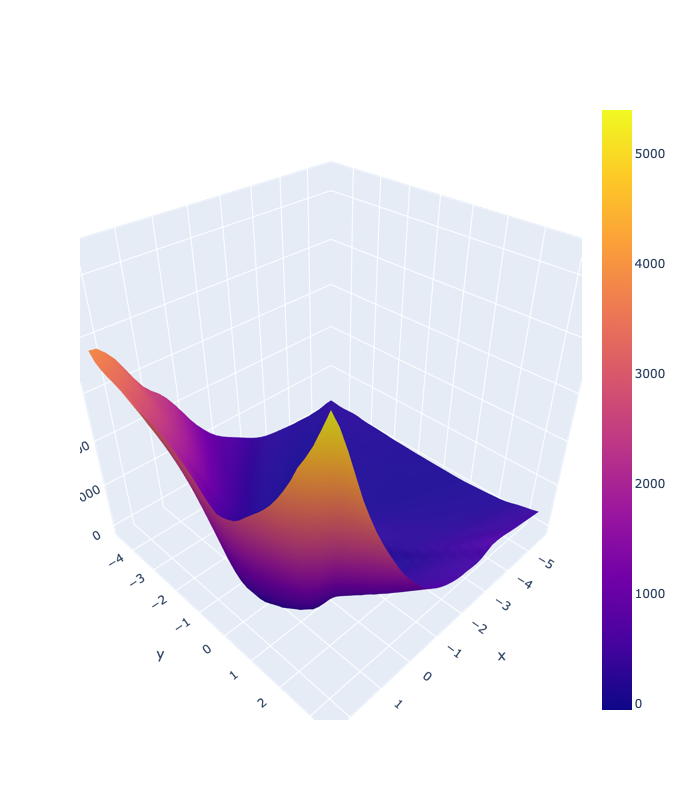

In [42]:
iplot(get_loss_landscape(get_loss_for_new_loss, 40, 4, 4, {'min_prec': 0.9, 'lmbda': 1e-3}))

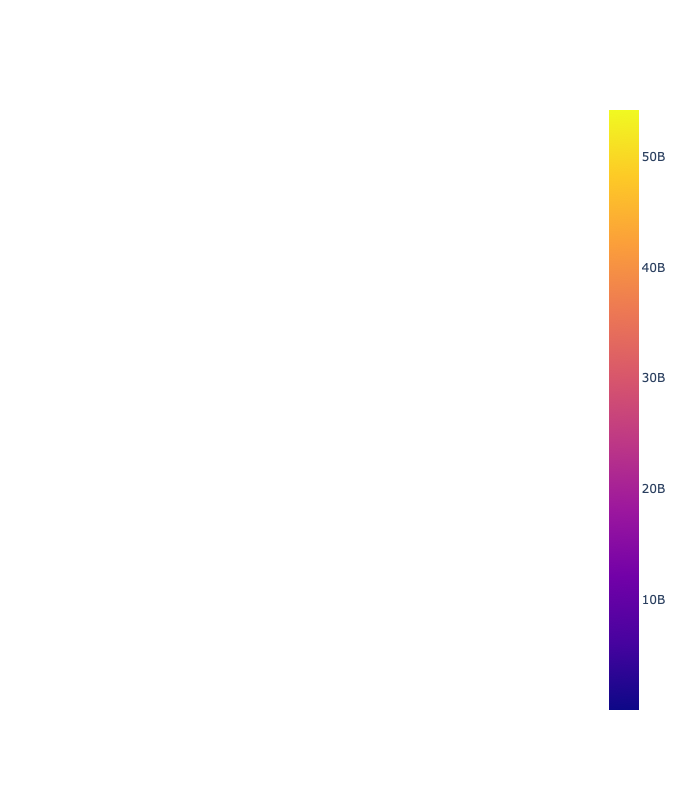

In [43]:
iplot(get_loss_landscape(get_loss_for_new_loss, 40, 4, 4, {'min_prec': 0.9, 'lmbda': 10000}))

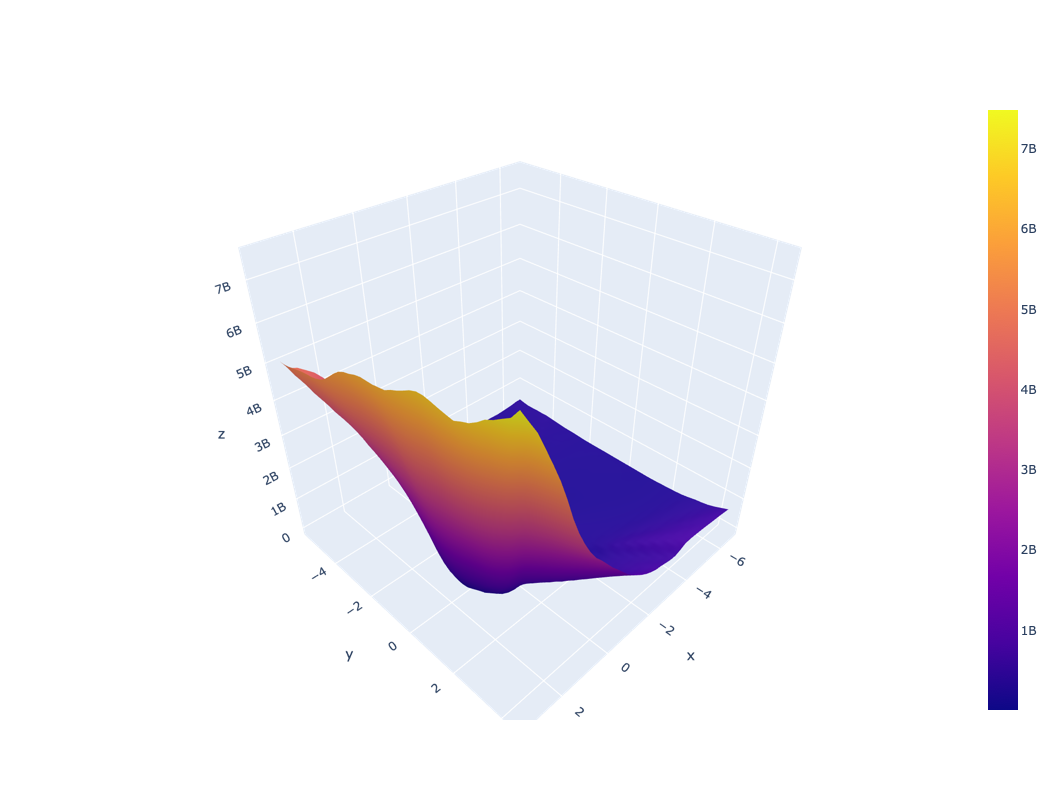

In [13]:
iplot(get_loss_landscape(get_loss_for_new_loss, 40, 5, 5, {'min_prec': 0.9, 'lmbda': 1000}))

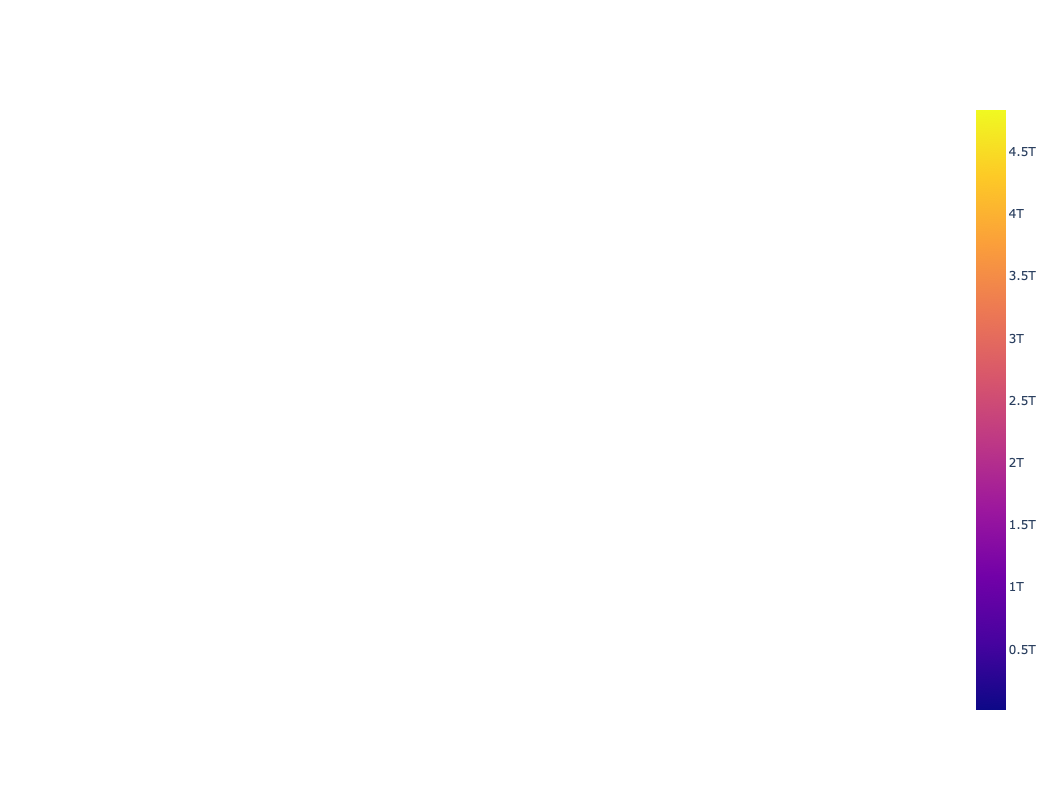

In [33]:
iplot(get_loss_landscape(get_loss_for_new_loss, 40, 3.3, 4, {'min_prec': 0.9, 'lmbda': 10000}))

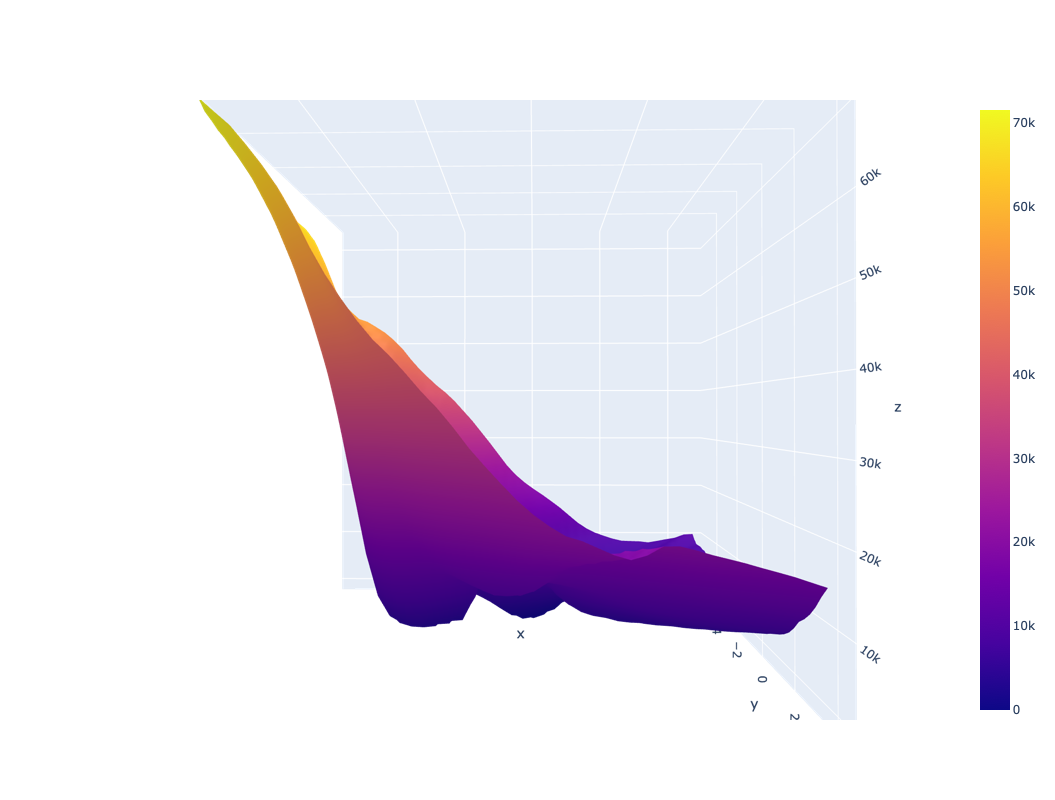

In [56]:
iplot(get_loss_landscape(get_loss_for_new_loss, 40, 5, 5, {'min_prec': 0.7}))

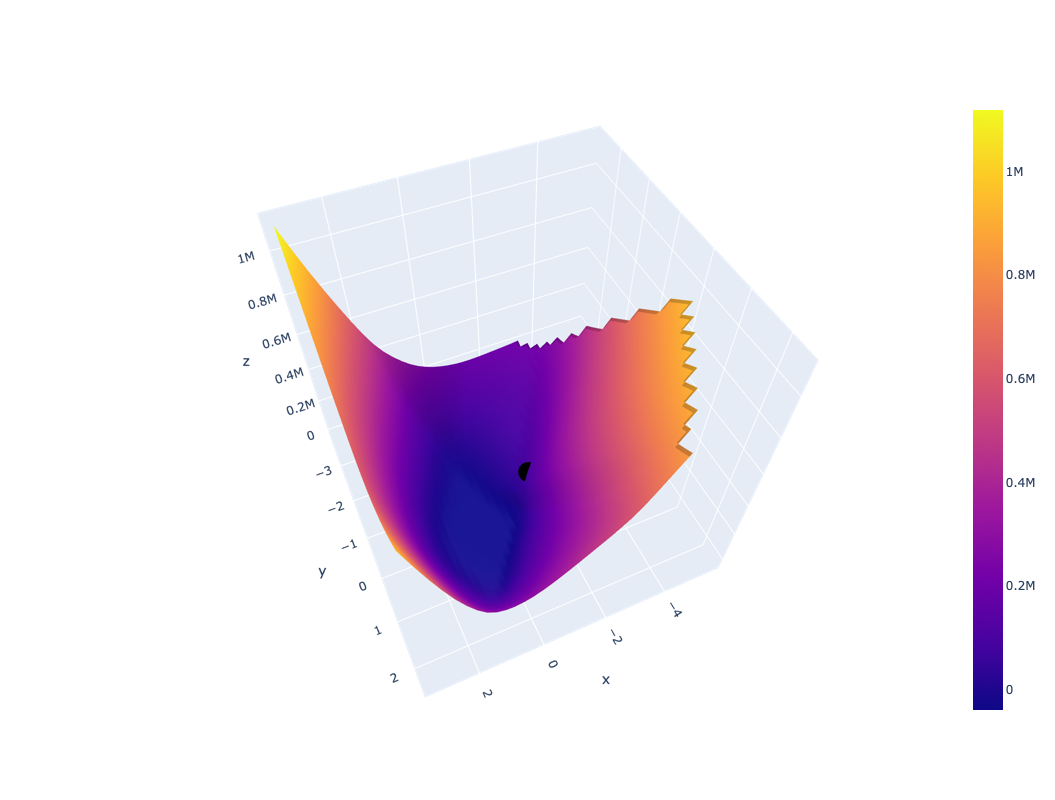

In [78]:
iplot(get_loss_landscape(get_loss_from_new_form, 40, 5, 3, {'min_prec': 0.8}))

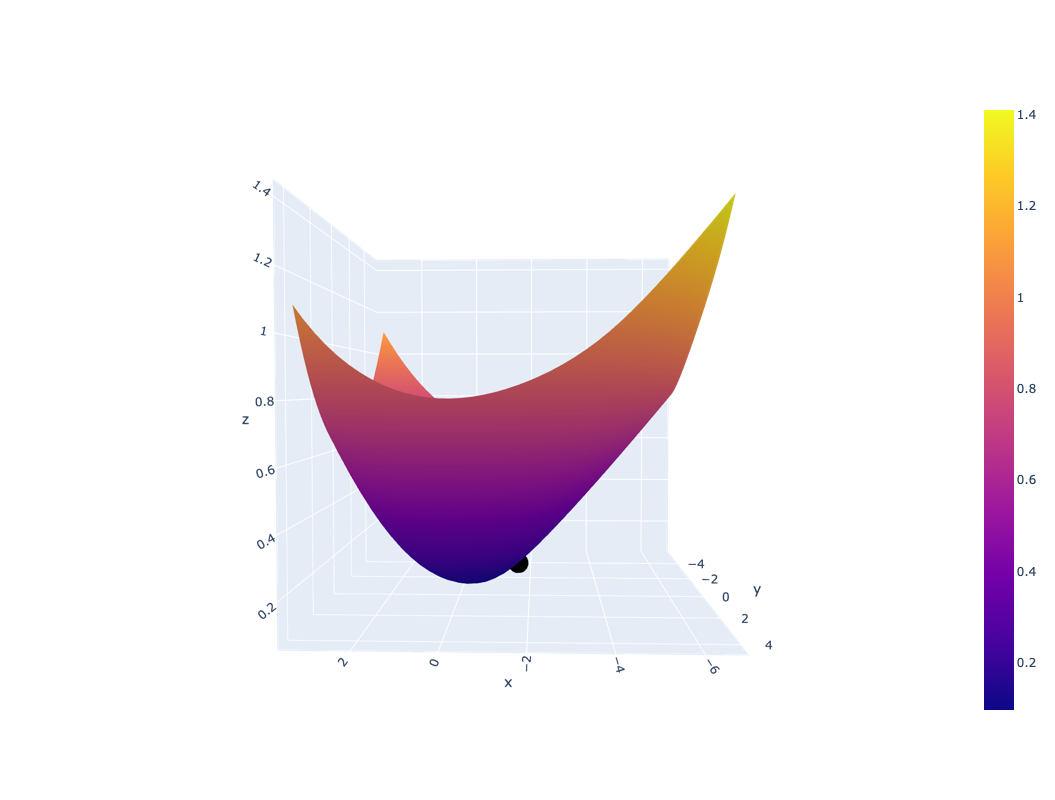

In [54]:
iplot(get_loss_landscape(get_loss_for_bce, 40, 5, 5))